In [103]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib as plot
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import nasdaqdatalink as nasdaq
import datetime

# Data Collection 

## Initial Considerations

### Market Variables

#### Federal Reserve Interest Rate
Interest rates released from the US Federal Reserve would act as a good indicator of stock prices. Interest rates are a tool used by the government to manage the markets, a high interest rate represents an attempt at slowing down the economy. Higher interest rates would lead to people and companies having a harder time getting loans. 

This would negatively impact 'growth' companies such as NVIDIA that relies on large amount of loans to further develop, whereas periods of low interest rates means loans are 'cheaper' to obtain, allowing growth companies to develop at a faster pace.

Interest rates could also introduce to the model a notion of 'inflation'. Interest rates are often raised by the government to combat inflation - through discouraging people from borrowing money and encouraging people to save money instead, this reduces the movement of money and the supply of money throughout the economy. As spending decreases, prices of goods and services would slowly go down.

#### Market Volatility
Market volatility is a measure of 'greed' and 'fear' investors have towards the markets, this can be tracked by the Cboe Volatility Index (VIX), which rises at times of high volatility (markets performing badly) and remains constant/drops at times when the markets perform.

#### Peer performances
Often than not, sentiment towards a industry acts a good indicator on how a company will perform. A overall negative sentiment towards the tech industry would lead to poor NVIDIA stock performance. A good "industry" predictor could be the SPDR Technology Sector Fund (XLK). XLK tracks the overall tech industry, and includes not just NVIDIA, but it's key competitiors such as Intel.

### Technical Variables

#### Stock Prices & Volume
Stock prices and volumes could possibly help us uncover patterns in price movements. An example would December, where it is commonly believed that most traders would try to sell off their stocks (especially those that underperformed) to claim capital losses (the investment asset being sold below the price it was brought for) to offset their taxable income. I hoped that possible patterns within price movements would be picked up by the model.

#### Moving Averages
Moving averages is used to create a 'average price range' that is 'constantly updated' at each moment of time. Since traders usually use moving averages to develop support and resistant lines (prices where they believe the stock would go further down or bounce back up), I hoped the model would be able to pick up on relationships between prices and the moving averages to develop patterns.


#### Bollinger Bands
Bollinger bands act as a representation of the 'likely range of stock movement' over the next period of time. The upper band represents a threshold where the stock is potentially 'over brought', meaning that the stock is trading at a value above what is is actual worth, whereas the lower band represents a threshold where the the stock is potentially 'over sold', meaning that the stock is trading below what it is actually worth.

## Final Choices
Keeping in data from VIX and XLK led to the model underperforming compared to one that just considers the interest rate, this could be due to the model not being able handle the greater complexity of drawing patterns from too much variables. Since the bollinger bands were calculated from the moving average, MA data was dropped too, the idea being 'information' about the moving average would also be conveyed via the bollinger bands. Keeping volume within the model also led to large deviations from the actual value and it did not seem to show any large relationship with the closing price from the graph plotted below, hence it was eventually removed as a predictor.

In [104]:
# Global Variables
NO_VAR = 7
START_D = '2015-01-01'
END_D = '2022-10-21'
DAYS_TO_PRED = 1
DAYS_USED_TO_PRED = 20
FINAL_DAYS_NEEDED = 10
PREDICTION_WINDOW = FINAL_DAYS_NEEDED
NASDAQ_DATA_LINK_API_KEY = 

In [105]:
def get_data_yf(start, end, ticker = 'NVDA'):
    """
    get_data_yf takes in 3 strings, a ticker (Default being NVDA), a start date and end date.
    It returns the historical stock price data from yahoo finance over the period of the start and end date.
    """
    
    df = yf.download(
        ticker,
        start = start,
        end = end
    )
    
    return df

In [106]:
# NVIDIA dataset
df = get_data_yf(START_D, END_D)

[*********************100%***********************]  1 of 1 completed


In [107]:
# XLK dataset
df_xlk = get_data_yf(START_D, END_D, 'XLK')

[*********************100%***********************]  1 of 1 completed


In [108]:
# VIX dataset
df_vix = get_data_yf(START_D, END_D, '^VIX')

[*********************100%***********************]  1 of 1 completed


In [109]:
# US Federal Reserve Interest Rate
nasdaq.ApiConfig.api_key = NASDAQ_DATA_LINK_API_KEY
df_ust = nasdaq.get("FED/RIFSPFF_N_D")

In [110]:
# Can use start date to extract needed interest rates since it is reported every day
df_ust = df_ust.loc[START_D:]

# Data Exploration 

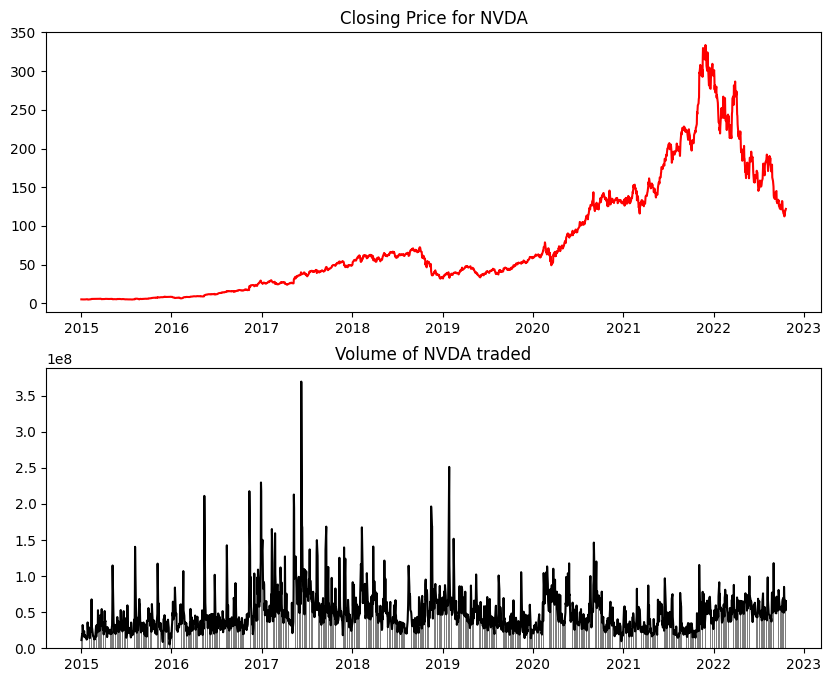

In [111]:
# Taking a look at volume vs stock price of NVIDIA
# Volume does not seem to correlate much with the stock prices.

plt.figure(figsize = (10,8))

plt.subplot(2,1,1)
plt.plot(df['Close'], color = 'red')
plt.title('Closing Price for NVDA')

plt.subplot(2,1,2)
plt.bar(df.index.values, df['Volume'], color = 'grey')
plt.plot(df['Volume'], color = 'black' )
plt.title('Volume of NVDA traded')
plt.show()

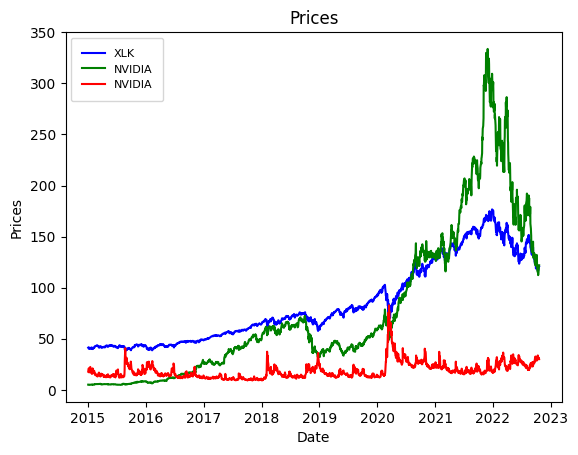

In [112]:
# XLK vs NVIDIA vs VIX prices
# Only discovered this just now - the red line represents VIX prices, not NVIDIA
plt.plot(df_xlk['Close'], color = 'blue', label = 'XLK')
plt.plot(df['Close'], color = 'green', label = 'NVIDIA')
plt.plot(df_vix['Close'], color = 'red', label = 'NVIDIA')
plt.title('Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc = 'upper left', borderpad = 1, fontsize = 8)
plt.show()

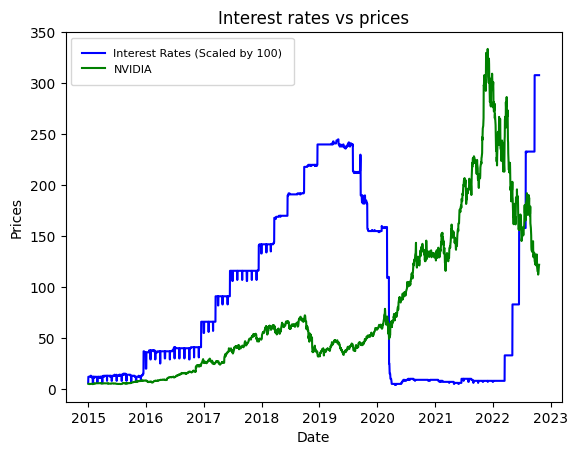

In [113]:
# Interest rate vs stock prices
plt.plot(df_ust['Value']*100, color = 'blue', label = 'Interest Rates (Scaled by 100)')
plt.plot(df['Close'], color = 'green', label = 'NVIDIA')
plt.title('Interest rates vs prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc = 'upper left', borderpad = 1, fontsize = 8)
plt.show()

In [114]:
# Check size
print('NVIDIA:' + str(df.shape) +
      ', Fed Interest rate: ' + str(df_ust.shape) + ', XLK:' + str(df_xlk.shape) + ', VIX:' + str(df_vix.shape))

# Check null values, length of treasury rate data is different because it includes weekends.
for ticker in [df, df_ust, df_xlk, df_vix]:
    print(str(ticker.isnull().values.any()))

NVIDIA:(1965, 6), Fed Interest rate: (2850, 1), XLK:(1965, 6), VIX:(1965, 6)
False
False
False
False


# Data Processing 

In [115]:
def bollinger_bands(df):
    """
    Takes in a dataframe with the SMA20 already calculated.
    Calculates and returns the same dataframe with the upper and lower bollinger bands.
    """
    
    # Calculate standard deviation
    std = df['SMA20'].rolling(20).std()
    
    df['lowerbol'] = df['SMA20'] + std * 2
    df['upperbol'] = df['SMA20'] - std * 2
    
    return df

In [116]:
def split(df, days_used_to_pred):
    """
    Takes in a dataframe and splits it into a training set and a testing set (1 set of timeframe for the model to predict.)
    It will then return the training set and testing set and the scaler function itself.
    """
    
    # Uncomment for: Split data for testing
    
    # Extract the training and testing set based on split calculated.
    df_train = df[DAYS_USED_TO_PRED + 20:]
    df_test = df[:DAYS_USED_TO_PRED + 20]
    
    # Uncomment for: Split data for final predictions
    # df_train = df
    # df_test = df[-(days_used_to_pred):]
    
    return df_train, df_test
    

In [117]:
def create_vars(df, timestep):
    """
    Takes in the data frame the time steps we are using to predict the values and the days to predict. 
    Normalises the independant variables before splitting and returning the independent and dependent variables as 2 seperate series.
    Returns the 2 seperate series together with the scaler used to normalised them.
    """   
    x = []
    y = []
    
    # Calculate the last set of days to be added to the list.
    end = len(df)- timestep
    
    # Standardise the dataframe
    scaler, df = standardise(df)
    
    # Split into x & y
    for i in range(end):
        
        # Gather the lists that are needed to extract x & y variables
        x_full = df[i : timestep + i]
        y_full = df[timestep + i]
        
        # Extract x and y variables from the lists gathered
        x_vars = [lst for lst in x_full]
            
        # Add the variables to the final x
        x.append(np.array(x_vars).astype(np.float32))
        
        # Add the variables to the final y
        y.append(np.array(y_full).astype(np.float32))
        
    # Convert to np arrays        
    x = np.array(x)
    y = np.array(y)
    
    # Convert to tensors 
    #x = tf.convert_to_tensor(np_x, dtype = np.float32)
    #y = tf.convert_to_tensor(np_y, dtype = np.float32)
    
    return scaler, x, y


In [118]:
def standardise(df):
    """
    Takes in a data frame and standardises values.
    Returns the normalised data as a numpy data frame.
    """
    
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    
    return scaler, df

In [119]:
# Create moving average
df['SMA20'] = df['Close'].rolling(20).mean()

# Create the bollinger bands
df = bollinger_bands(df)

# Drop first 40 days (No MA/bollinger values)
df = df[40:]

df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA20,lowerbol,upperbol
Date,,,,,,,,,
2015-03-03 00:00:00-05:00,5.6075,5.635,5.5275,5.5450,5.349212,16034400,5.407250,5.692609,5.121891
2015-03-04 00:00:00-05:00,5.5250,5.620,5.5025,5.6075,5.409504,22684000,5.436250,5.735401,5.137099
2015-03-05 00:00:00-05:00,5.6075,5.725,5.5925,5.7150,5.513209,32305600,5.470000,5.782429,5.157571
2015-03-06 00:00:00-05:00,5.6825,5.710,5.6325,5.6375,5.438447,25739200,5.495750,5.819871,5.171629
2015-03-09 00:00:00-04:00,5.6400,5.695,5.6275,5.6525,5.452916,22238800,5.523375,5.856337,5.190413


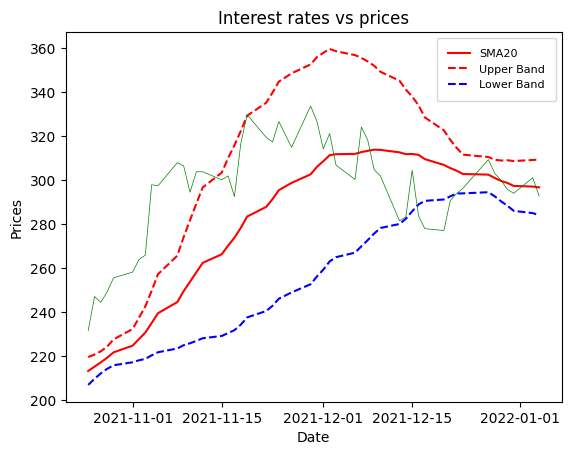

In [120]:
# Plot 20MA & Bollinger bands with random section in the dataframe to view results
df_sma_test = df[-250:-200]

plt.plot(df_sma_test['SMA20'], color = 'red', label = 'SMA20')
plt.plot(df_sma_test['lowerbol'], color = 'red', label = 'Upper Band', linestyle = 'dashed')
plt.plot(df_sma_test['upperbol'], color = 'blue', label = 'Lower Band', linestyle = 'dashed')
plt.plot(df_sma_test['Close'], color = 'green', linewidth = 0.5)
plt.title('Interest rates vs prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend(loc = 'upper right', borderpad = 1, fontsize = 8)
plt.show()

In [121]:
df_ust.head(10)

,Value
Date,
2015-01-01,0.06
2015-01-02,0.12
2015-01-03,0.12
2015-01-04,0.12
2015-01-05,0.12
2015-01-06,0.12
2015-01-07,0.12
2015-01-08,0.12
2015-01-09,0.12


In [122]:
# Add XLK, VIX
#df['XLK'] = df_xlk['Close']
#df['VIX'] = df_vix['Close']
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA20,lowerbol,upperbol
Date,,,,,,,,,
2015-03-03 00:00:00-05:00,5.6075,5.635,5.5275,5.5450,5.349212,16034400,5.407250,5.692609,5.121891
2015-03-04 00:00:00-05:00,5.5250,5.620,5.5025,5.6075,5.409504,22684000,5.436250,5.735401,5.137099
2015-03-05 00:00:00-05:00,5.6075,5.725,5.5925,5.7150,5.513209,32305600,5.470000,5.782429,5.157571
2015-03-06 00:00:00-05:00,5.6825,5.710,5.6325,5.6375,5.438447,25739200,5.495750,5.819871,5.171629
2015-03-09 00:00:00-04:00,5.6400,5.695,5.6275,5.6525,5.452916,22238800,5.523375,5.856337,5.190413


In [123]:
df.head(50)

,Open,High,Low,Close,Adj Close,Volume,SMA20,lowerbol,upperbol
Date,,,,,,,,,
2015-03-03 00:00:00-05:00,5.6075,5.6350,5.5275,5.5450,5.349212,16034400,5.407250,5.692609,5.121891
2015-03-04 00:00:00-05:00,5.5250,5.6200,5.5025,5.6075,5.409504,22684000,5.436250,5.735401,5.137099
2015-03-05 00:00:00-05:00,5.6075,5.7250,5.5925,5.7150,5.513209,32305600,5.470000,5.782429,5.157571
2015-03-06 00:00:00-05:00,5.6825,5.7100,5.6325,5.6375,5.438447,25739200,5.495750,5.819871,5.171629
2015-03-09 00:00:00-04:00,5.6400,5.6950,5.6275,5.6525,5.452916,22238800,5.523375,5.856337,5.190413
2015-03-10 00:00:00-04:00,5.6775,5.7875,5.6675,5.7500,5.546975,52721200,5.556125,5.895396,5.216854
2015-03-11 00:00:00-04:00,5.7500,5.8250,5.7050,5.7200,5.518034,26212000,5.580250,5.923026,5.237473
2015-03-12 00:00:00-04:00,5.6650,5.7075,5.5600,5.6675,5.467387,40697200,5.603500,5.946435,5.260565
2015-03-13 00:00:00-04:00,5.6400,5.6900,5.5625,5.6750,5.474623,35928800,5.608500,5.948396,5.268604


In [124]:
# Change the date index column for the dataframe.
df.reset_index(inplace = True)
df['Date'] = df['Date'].dt.date
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,SMA20,lowerbol,upperbol
Date,,,,,,,,,
2015-03-03,5.607500,5.635000,5.527500,5.545000,5.349212,16034400,5.407250,5.692609,5.121891
2015-03-04,5.525000,5.620000,5.502500,5.607500,5.409504,22684000,5.436250,5.735401,5.137099
2015-03-05,5.607500,5.725000,5.592500,5.715000,5.513209,32305600,5.470000,5.782429,5.157571
2015-03-06,5.682500,5.710000,5.632500,5.637500,5.438447,25739200,5.495750,5.819871,5.171629
2015-03-09,5.640000,5.695000,5.627500,5.652500,5.452916,22238800,5.523375,5.856337,5.190413
...,...,...,...,...,...,...,...,...,...
2022-10-14,120.570000,121.110001,112.040001,112.269997,112.269997,71255100,124.334500,138.270667,110.398332
2022-10-17,115.180000,119.480003,115.169998,118.879997,118.879997,58077400,123.587499,136.421834,110.753165
2022-10-18,123.440002,124.919998,116.180000,119.669998,119.669998,65936200,122.982999,134.719758,111.246240


In [125]:
# Add Interest date data only when date matches.
df = pd.merge(df, df_ust, left_index = True, right_index = True)

df.drop(['SMA20', 'Adj Close', 'Volume'], axis = 1, inplace = True)

# Rename 'Value' column
df = df.rename({'Value' : 'IntRate'}, axis = 1)

In [126]:
# Check final df
df.head()

,Open,High,Low,Close,lowerbol,upperbol,IntRate
Date,,,,,,,
2015-03-03,5.6075,5.635,5.5275,5.5450,5.692609,5.121891,0.12
2015-03-04,5.5250,5.620,5.5025,5.6075,5.735401,5.137099,0.11
2015-03-05,5.6075,5.725,5.5925,5.7150,5.782429,5.157571,0.11
2015-03-06,5.6825,5.710,5.6325,5.6375,5.819871,5.171629,0.12
2015-03-09,5.6400,5.695,5.6275,5.6525,5.856337,5.190413,0.12


In [127]:
df_train, df_test = split(df, DAYS_USED_TO_PRED)
df_train

,Open,High,Low,Close,lowerbol,upperbol,IntRate
Date,,,,,,,
2015-04-29,5.537500,5.592500,5.512500,5.535000,5.594373,5.468127,0.13
2015-04-30,5.507500,5.577500,5.495000,5.550000,5.601911,5.490339,0.08
2015-05-01,5.595000,5.705000,5.570000,5.687500,5.623563,5.510937,0.13
2015-05-04,5.682500,5.720000,5.635000,5.652500,5.639948,5.518052,0.13
2015-05-05,5.632500,5.640000,5.482500,5.507500,5.647627,5.514623,0.13
...,...,...,...,...,...,...,...
2022-10-14,120.570000,121.110001,112.040001,112.269997,138.270667,110.398332,3.08
2022-10-17,115.180000,119.480003,115.169998,118.879997,136.421834,110.753165,3.08
2022-10-18,123.440002,124.919998,116.180000,119.669998,134.719758,111.246240,3.08


In [128]:
scaler_used, x_train, y_train = create_vars(df_train, DAYS_USED_TO_PRED)

# Check that the split is conducted and x, y variable split successfully.
x_train[0]

array([[-1.005335  , -1.0032533 , -1.0086325 , -1.0064803 , -0.9935033 ,
        -1.0047323 , -0.912888  ],
       [-1.0057346 , -1.0034488 , -1.0088714 , -1.0062803 , -0.9934096 ,
        -1.0044128 , -0.9707952 ],
       [-1.0045694 , -1.0017866 , -1.0078477 , -1.0044469 , -0.9931406 ,
        -1.0041165 , -0.912888  ],
       [-1.0034043 , -1.0015911 , -1.0069604 , -1.0049136 , -0.99293697,
        -1.0040141 , -0.912888  ],
       [-1.00407   , -1.002634  , -1.009042  , -1.0068469 , -0.99284154,
        -1.0040635 , -0.912888  ],
       [-1.005335  , -1.0032859 , -1.0094515 , -1.0066136 , -0.9927578 ,
        -1.0041317 , -0.912888  ],
       [-1.0058011 , -1.002634  , -1.0090079 , -1.0053136 , -0.9927023 ,
        -1.0042104 , -0.912888  ],
       [-1.0091301 , -1.0049807 , -1.0139561 , -1.0108471 , -0.99298364,
        -1.0045786 , -0.912888  ],
       [-1.0106947 , -1.00824   , -1.0143315 , -1.0115137 , -0.9932807 ,
        -1.0049251 , -0.912888  ],
       [-1.0108945 , -1.0077

In [129]:
# Check y_train is the last input for the next x_train
x_train[1]

array([[-1.0057346 , -1.0034488 , -1.0088714 , -1.0062803 , -0.9934096 ,
        -1.0044128 , -0.9707952 ],
       [-1.0045694 , -1.0017866 , -1.0078477 , -1.0044469 , -0.9931406 ,
        -1.0041165 , -0.912888  ],
       [-1.0034043 , -1.0015911 , -1.0069604 , -1.0049136 , -0.99293697,
        -1.0040141 , -0.912888  ],
       [-1.00407   , -1.002634  , -1.009042  , -1.0068469 , -0.99284154,
        -1.0040635 , -0.912888  ],
       [-1.005335  , -1.0032859 , -1.0094515 , -1.0066136 , -0.9927578 ,
        -1.0041317 , -0.912888  ],
       [-1.0058011 , -1.002634  , -1.0090079 , -1.0053136 , -0.9927023 ,
        -1.0042104 , -0.912888  ],
       [-1.0091301 , -1.0049807 , -1.0139561 , -1.0108471 , -0.99298364,
        -1.0045786 , -0.912888  ],
       [-1.0106947 , -1.00824   , -1.0143315 , -1.0115137 , -0.9932807 ,
        -1.0049251 , -0.912888  ],
       [-1.0108945 , -1.0077184 , -1.0140244 , -1.0108471 , -0.99351704,
        -1.0052017 , -0.912888  ],
       [-1.00923   , -1.0072

In [130]:
y_train[0]

array([-1.006367 , -1.0037748, -1.0094857, -1.0064803, -0.9943535,
       -1.0083073, -0.9244695], dtype=float32)

In [131]:
print("X variables shape: " + str(x_train.shape) + 
      ", Y variables shape: " + str(y_train.shape))

X variables shape: (1865, 20, 7), Y variables shape: (1865, 7)


# Building the model

### Choice of model: Stacked LSTM

### Reasoning

LSTM are able to discover more patterns compared to ARIMA and Linear Regression and are able to work with non-stationary data. They are also able to pick up non-linear relationships between various data attributes, hopefully contributing to better predictions.

Unlike ARIMA models, LSTMs work well in processing and uncovering patterns from large amounts of data, allowing us to leverage on years of collected data for our selected attributes.

A stacked LSTM is used over a vanilla LSTM as it adds more hidden layers that produce a sequenced output to the layer below, which could helps it better discover patterns related to sequence-related problems.

In [132]:
# Define some parameters
EPOCHS = 10 #10 #100
BATCH_SIZE = 15
INPUT_SHAPE = (DAYS_USED_TO_PRED, NO_VAR)
VALIDATION_SPLIT = 0.1

In [133]:
# Define model
model = keras.Sequential([
    
    keras.layers.LSTM(64, return_sequences = True, input_shape = INPUT_SHAPE, activation = 'relu'), #64
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences = True, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences = True, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences = True, activation = 'relu'), #32
    keras.layers.Dropout(0.2),
    #keras.layers.LSTM(32, return_sequences = True, activation = 'relu'),
    
    # Final Output
    #keras.layers.Dense(NO_VAR)
    keras.layers.LSTM(NO_VAR, activation = 'linear')
])

model.compile(optimizer = 'adam',
             loss = 'mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 20, 64)            18432     
                                                                 
 dropout_8 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 20, 128)           98816     
                                                                 
 dropout_9 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_12 (LSTM)              (None, 20, 128)           131584    
                                                                 
 dropout_10 (Dropout)        (None, 20, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 64)           

In [134]:
# Train Model
x_train_ = x_train.reshape(-1, DAYS_USED_TO_PRED, NO_VAR)
model.fit(x_train_, y_train, epochs = EPOCHS, validation_split = VALIDATION_SPLIT, batch_size = BATCH_SIZE)

Epoch 1/10
112/112 [==============================] - 8s 39ms/step - loss: 2.4654 - val_loss: 1.2106
Epoch 2/10
112/112 [==============================] - 4s 39ms/step - loss: 0.1713 - val_loss: 0.6096
Epoch 3/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0767 - val_loss: 0.3830
Epoch 4/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0484 - val_loss: 0.4189
Epoch 5/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0364 - val_loss: 0.3275
Epoch 6/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0306 - val_loss: 0.2697
Epoch 7/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0281 - val_loss: 0.3510
Epoch 8/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0238 - val_loss: 0.4016
Epoch 9/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0251 - val_loss: 0.3900
Epoch 10/10
112/112 [==============================] - 4s 39ms/step - loss: 0.0231 - val_lo

# Model Evaluation

In [135]:
def get_rsme(predicted, actual):
    """
    Takes in dataframe of predicted and actual and calculates the RSME of the results.
    """

    # Rename columns    
    df = predicted.rename({'Close' : 'Predicted'}, axis = 1)
    
    # Convert actual to dataframe
    actual = pd.DataFrame(actual, columns = ['Close'])
    
    # Merge columns together
    df['Actual'] = actual['Close']
    
    
    # Calculate RMSE
    results = (((df['Predicted'] - df['Actual']) ** 2).mean()) ** 0.5 
    print("RSME: " + str(round(results, 2)))
    
    # Return created table & RSME
    return df, results

<function matplotlib.pyplot.show(close=None, block=None)>

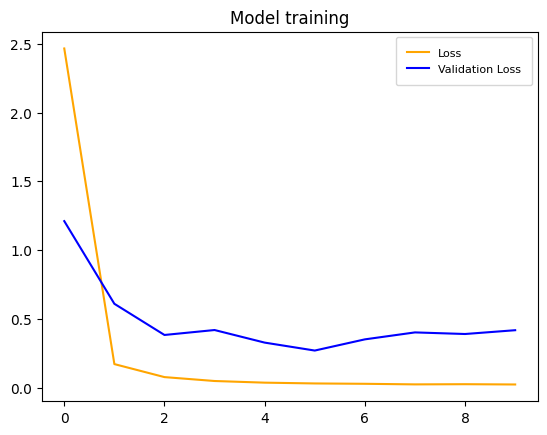

In [136]:
# Plot Model training history
history = model.history.history
loss = history['loss']
val_loss = history['val_loss']

plt.title('Model training')
plt.plot(loss, color = 'orange', label = 'Loss')
plt.plot(val_loss, color = 'blue', label = 'Validation Loss')
plt.legend(loc = 'upper right', borderpad = 1, fontsize = 8)
plt.show

In [137]:
df_test

,Open,High,Low,Close,lowerbol,upperbol,IntRate
Date,,,,,,,
2015-03-03,5.6075,5.6350,5.5275,5.5450,5.692609,5.121891,0.12
2015-03-04,5.5250,5.6200,5.5025,5.6075,5.735401,5.137099,0.11
2015-03-05,5.6075,5.7250,5.5925,5.7150,5.782429,5.157571,0.11
2015-03-06,5.6825,5.7100,5.6325,5.6375,5.819871,5.171629,0.12
2015-03-09,5.6400,5.6950,5.6275,5.6525,5.856337,5.190413,0.12
2015-03-10,5.6775,5.7875,5.6675,5.7500,5.895396,5.216854,0.12
2015-03-11,5.7500,5.8250,5.7050,5.7200,5.923026,5.237473,0.11
2015-03-12,5.6650,5.7075,5.5600,5.6675,5.946435,5.260565,0.11
2015-03-13,5.6400,5.6900,5.5625,5.6750,5.948396,5.268604,0.11


In [138]:
x_test = df_test[:DAYS_USED_TO_PRED]
y_test = df_test[DAYS_USED_TO_PRED:]

In [139]:
print("X variables shape: " + str(x_test.shape) + ", Y variables shape: " + str(y_test.shape))

X variables shape: (20, 7), Y variables shape: (20, 7)


In [140]:
def predict_y(n, df):
    """
    Takes in number of days for the model to predict and a numpy array used for prediction.
    Returns predictions for the next few days using a rolling window method,
    where each prediction would be passed back into the model to form the next new prediction.
    """
    
    # Normalise the dataframe
    df = scaler_used.fit_transform(df)
    
    predictions = []
    
    # Iterate through the values
    for i in range(n):
        
        # Reshape the data for the prediction
        df = df.reshape(-1, DAYS_USED_TO_PRED, NO_VAR)
        
        # Generate prediction and add it to the prediction
        prediction = model.predict(df)
        predictions.append(prediction[0])
        
        # Create the next data frame used for the prediction
        
        # Drop first day from the data frame
        df = df[0][1:]
        
        # Add predicted next day to the data frame
        df = np.concatenate((df, prediction), axis = 0)

    return predictions

In [141]:
def inverse(predictions):
    """
    Takes in a series of predictions and transforms them back to the original values.
    Returns the predictions as their original values.
    """
    
    # Convert rows of predictions into a dataframe
    df = pd.DataFrame(predictions)
    
    # Transforms the predictions back to original values
    df = scaler_used.inverse_transform(df)
    
    return df

In [142]:
def gather_results(index, predictions):
    """
    Takes in index of results we want and the final transformed predictions.
    Returns the final transformed predictions in a list.
    """
    
    return [lst[index] for lst in predictions]

In [143]:
y_pred = predict_y(len(y_test), x_test)
y_pred = inverse(y_pred)
y_pred = gather_results(3, y_pred)

1/1 [==============================] - 0s 14ms/step


In [144]:
# Convert gathered results into a dataframe so that we can plot the results
y_pred = pd.DataFrame(y_pred, columns = ['Close'])
y_pred['Dates'] = y_test.index
y_pred = y_pred.set_index('Dates')

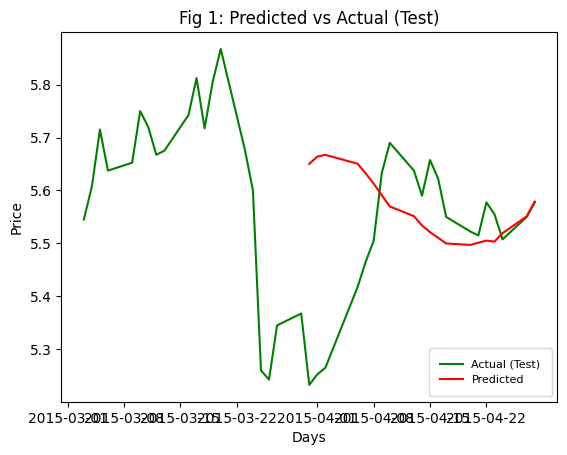

In [145]:
# Plot results of predictions against test data
y_actual = df_test['Close']

plt.plot(y_actual, color = 'green', label = 'Actual (Test)')
plt.plot(y_pred['Close'], color = 'red', label = 'Predicted')
plt.title('Fig 1: Predicted vs Actual (Test)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc = 'lower right', borderpad = 1, fontsize = 8)

In [146]:
# Check fit against training data
train_pred_x = df_train[ -(DAYS_USED_TO_PRED + 10): -10]
train_pred_actual = df_train[ -(10 + DAYS_USED_TO_PRED):]

train_pred_pred = predict_y(len(train_pred_actual), train_pred_x)
train_pred_pred = inverse(train_pred_pred)
train_pred_pred = gather_results(3, train_pred_pred)

1/1 [==============================] - 0s 14ms/step


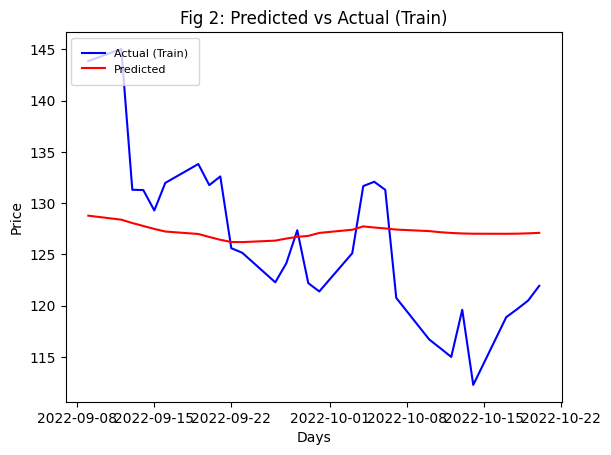

In [147]:
# Plot fit against training data
train_pred_pred = pd.DataFrame(train_pred_pred, columns = ['Close'])
train_pred_pred['Dates'] = train_pred_actual.index
train_pred_pred = train_pred_pred.set_index('Dates')

plt.plot(train_pred_actual['Close'], color = 'blue', label = 'Actual (Train)')
plt.plot(train_pred_pred['Close'], color = 'red', label = 'Predicted')
plt.title('Fig 2: Predicted vs Actual (Train)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc = 'upper left', borderpad = 1, fontsize = 8)

In [148]:
# Calculate RSME for the first 10 days of predictions

print('RSME on testing data:')
pred_on_test, RSME = get_rsme(y_pred, y_actual)
print('\n')
print('RSME on training data:')
pred_on_train, _ = get_rsme(train_pred_pred[:11], train_pred_actual[:11])

RSME on testing data:
RSME: 0.18


RSME on training data:
RSME: 7.78


In [150]:
# Save model if it produces good results
name = "fin_model_" + str(RSME) + "_best.h5" 
#model.save(name)

While the validation loss failed to fully converge with the training loss, from Fig 1, we are able to see that the model is able to make decent predictions on the test data (data it has never seen before).

It also does not seem that the model has been overfitted on the training data from Fig 2.

# Final Predictions

In [151]:
# Import best model
#model = keras.models.load_model("fin_model_0.19810370721_best.h5")

In [152]:
# Generate predictions
x_final = df_train[-DAYS_USED_TO_PRED:]
x_final = predict_y(10, x_final)
x_final = inverse(x_final)
x_final = gather_results(3, x_final)

# Create the daterange
range1 = pd.date_range("2022-10-24", "2022-10-28") 
range2 = pd.date_range("2022-10-31", "2022-11-04")

final_range = range1.union(range2)

# Add predictions into a dataframe
final_predictions = pd.DataFrame(x_final, columns = ['Close'])
final_predictions['Dates'] = final_range
final_predictions = final_predictions.set_index('Dates')

1/1 [==============================] - 0s 14ms/step


In [153]:
final_predictions

,Close
Dates,
2022-10-24,122.158913
2022-10-25,121.595467
2022-10-26,121.067955
2022-10-27,120.560333
2022-10-28,120.081505
2022-10-31,119.742355
2022-11-01,119.444839
2022-11-02,119.127022
2022-11-03,118.867165


In [154]:
# Reformat and extract predictions into a final csv file
final_predictions = final_predictions.reset_index(drop = True)
final_predictions.index.name = 'Index'
final_predictions.to_csv('Yeo_Shu_Heng_Impl1.csv')